# Matrix factorizations

1. Compare PCA, SVD, ALS on random matrix
2. Get familiar with music dataset
3. Look at item2item similarities for music

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
A = np.random.randn(8, 5)
A

array([[ 0.08181712, -0.78378128, -1.96953579,  0.11612118, -0.63456   ],
       [ 0.75362632,  0.49536099, -0.31452712, -1.06194306, -0.40803442],
       [ 0.75841923, -1.35624471,  1.62974757, -0.21753049, -0.16488684],
       [ 0.93196253, -1.55154829, -0.74010228,  2.43004486,  0.11537723],
       [ 0.13131419, -0.54525311,  0.62427159, -1.24987243, -0.8025712 ],
       [ 0.67554779,  0.47545261, -0.59701767,  1.70858858,  1.46370622],
       [ 0.08278009, -0.17547587,  0.45567126,  1.05637436, -0.91609338],
       [ 3.00845926, -1.80933803, -1.46671034, -0.95233641,  1.08764166]])

# PCA

In [6]:
def center_mass(A):
    return A.mean(0)

def covariance(A): # size = n * p -> p * p
    A_norm = A - center_mass(A) # n * p
    return A_norm.T @ A_norm

In [7]:
assert covariance(A).shape == (A.shape[1], A.shape[1])
assert center_mass(A).shape == (A.shape[1],)
assert np.allclose(covariance(A), covariance(A).T)

In [9]:
def eig_values(Q):
    return np.linalg.eigh(Q)[0]

def eig_vectors(Q):
    return np.linalg.eigh(Q)[1]

In [10]:
Q = covariance(A)
D, V = eig_values(Q), eig_vectors(Q)

assert D.shape == (A.shape[1],)
assert V.shape == (A.shape[1], A.shape[1])
assert np.allclose(np.sort(D), D)
assert np.allclose(V.T.dot(V), np.eye(A.shape[1]))
assert np.allclose(V.dot(V.T), np.eye(A.shape[1]))
assert np.allclose(np.trace(covariance(A)), D.sum())
assert np.allclose(V.dot(np.diag(D)).dot(V.T), Q)

Formula for pca: $A=U S V^T + {\rm center\space mass}$

In [11]:
def pca_decomposition(A, k: int): # n * p; k - features to stay
    Q = covariance(A)
    D = eig_values(Q)
    V = eig_vectors(Q)
    
    S = np.diag(np.sqrt(D[:k]))
    MA = center_mass(A)
    A_norm = A - MA
    U = (A_norm @ V @ np.diag(1/np.sqrt(D)))[:, :k]
    V = V[:, :k]
    return U, S, V, MA

def pca_recover(U, S, V, MA):
    return U @ S @ V.T + MA

In [12]:
k = 2
U, S, V, MA = pca_decomposition(A, k)

assert pca_recover(U, S, V, MA).shape == A.shape
assert U.shape == (A.shape[0], k)
assert S.shape == (k, k)
assert V.shape == (A.shape[1], k)
assert MA.shape == (A.shape[1],)
assert np.allclose(S, np.diag(S.diagonal()))
assert np.allclose(np.sort(S.diagonal()), S.diagonal())
assert np.allclose(U.T.dot(U), np.eye(k))
assert np.allclose(V.T.dot(V), np.eye(k))
assert not np.allclose(V.dot(V.T), np.eye(V.shape[0]))
assert not np.allclose(U.dot(U.T), np.eye(U.shape[0]))
assert np.allclose(pca_recover(*pca_decomposition(A, A.shape[1])), A)

In [13]:
frobenius_norms = []

for k in range(0, 6):
    U, S, V, MA = pca_decomposition(A, k)
    AA = pca_recover(U, S, V, MA)
    frobenius_norms.append(np.sum((A-AA)**2))

print(*["{:.2f}".format(x) for x in frobenius_norms])

# assert np.allclose(frobenius_norms[::-1], [0] + list(np.cumsum(eig_values(covariance(A)))))

40.05 39.49 34.95 28.21 14.83 0.00


In [42]:
frobenius_norms[::-1], [0] + list(np.cumsum(eig_values(covariance(A))))

([5.983719892465313e-30,
  18.414033879667848,
  28.114777666038783,
  34.93135044219111,
  39.00990768097294,
  39.60515224069629],
 [0,
  0.5952445597233639,
  4.673801798505189,
  11.490374574657517,
  21.191118361028447,
  39.605152240696285])

# SVD

Formula for svd: $A=U S V^T$

In [14]:
def svd_decomposition(A, k: int): # n * p; k - features to stay
    Q = covariance(A)
    D = eig_values(Q)
    V = eig_vectors(Q)
    p = A.shape[1]
    l = k # features to stay
    S = np.diag(np.sqrt(D[:l]))
    A_norm = A
    U = (A_norm @ V @ np.diag(1/np.sqrt(D)))[:, :l]
    V = V[:, :l]
    return U, S, V

def svd_recover(U, S, V):
    return U @ S @ V.T

In [46]:
k = 2
U, S, V = svd_decomposition(A, k)

assert svd_recover(U, S, V).shape == A.shape
assert U.shape == (A.shape[0], k)
assert S.shape == (k, k)
assert V.shape == (A.shape[1], k)
assert np.allclose(S, np.diag(S.diagonal()))
assert np.allclose(np.sort(S.diagonal()), S.diagonal())
assert np.allclose(U.T.dot(U), np.eye(k))
assert np.allclose(V.T.dot(V), np.eye(k))
assert not np.allclose(V.dot(V.T), np.eye(V.shape[0]))
assert not np.allclose(U.dot(U.T), np.eye(U.shape[0]))
assert np.allclose(svd_recover(*svd_decomposition(A, A.shape[1])), A)

AssertionError: 

In [15]:
frobenius_norms = []
for k in range(0, 6):
    U, S, V = svd_decomposition(A, k)
    AA = svd_recover(U, S, V)
    frobenius_norms.append(np.sum((A-AA)**2))

print(*["{:.2f}".format(x) for x in frobenius_norms])
# assert np.allclose(frobenius_norms[::-1], [0] + list(np.cumsum(eig_values(A.T.dot(A)))))

49.79 48.16 42.01 33.76 17.48 0.00


# ALS

In [27]:
k = 2
lam = 1e-4

In [28]:
def calc_oposite_vectors(Y, A):
    B = Y.T @ Y + lam * np.eye(k)
    C = A @ Y
    return (np.linalg.inv(B) @ C.T).T

14.178250118805757


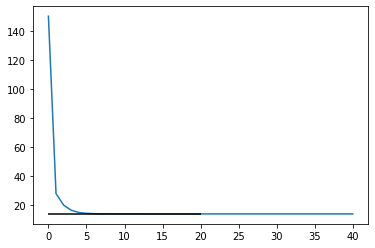

In [44]:
def als_decomposition(A, k, lam, debug: bool = True):
    X, Y = np.random.randn(A.shape[0], k), np.random.randn(A.shape[1], k)
    if debug:
        frobenius_norms = [np.sum((A - X.dot(Y.T))**2)]
    else:
        frobenius_norms = None

    for i in range(20):
        X = calc_oposite_vectors(Y, A)
        if debug:
            frobenius_norms.append(np.sum((A - X.dot(Y.T))**2))

        Y = calc_oposite_vectors(X, A.T)
        if debug:
            frobenius_norms.append(np.sum((A - X.dot(Y.T))**2))
        
    return X, Y, frobenius_norms

X, Y, frobenius_norms = als_decomposition(A, k, lam)
plt.plot(frobenius_norms)
plt.hlines(np.cumsum(eig_values(A.T.dot(A)))[A.shape[1]-k-1], 0, 20, color='black')

print(frobenius_norms[-1])

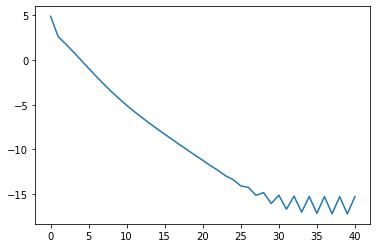

In [45]:
plt.plot(np.log(frobenius_norms-np.cumsum(eig_values(A.T.dot(A)))[A.shape[1]-k-1]))

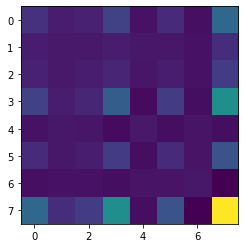

In [31]:
plt.imshow(X.dot(X.T))

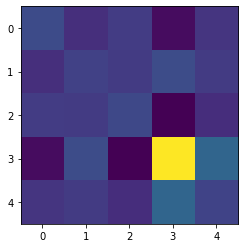

In [33]:
plt.imshow(Y.dot(Y.T))

In [35]:
AA_svd = svd_recover(*svd_decomposition(A, k))
AA_als = X.dot(Y.T)
assert np.allclose(AA_svd, AA_als, rtol=1e-3, atol=1e-3)

AssertionError: 

## Compare SVD and ALS

In [50]:
n_users = 10**8
n_items = 3000

In [51]:
%%timeit
B = np.random.randn(n_users, n_items)
k = 2
lam = 1e-4

svd_decomposition(B, k)

/var/folders/cx/c_0x0d9s0ws_txrc3zdtxfq1lnj83m/T/ipykernel_36885/2036311295.py:7: RuntimeWarning: invalid value encountered in sqrt
  S = np.diag(np.sqrt(D[:l]))
/var/folders/cx/c_0x0d9s0ws_txrc3zdtxfq1lnj83m/T/ipykernel_36885/2036311295.py:9: RuntimeWarning: invalid value encountered in sqrt
  U = (A_norm @ V @ np.diag(1/np.sqrt(D)))[:, :l]


12.5 s ± 1.39 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
%%timeit
B = np.random.randn(n_users, n_items)
k = 2
lam = 1e-4

als_decomposition(B, k, lam, debug=False)

165 ms ± 18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Music dataset

Files to download:
- Feedbacks matrix: https://disk.yandex.ru/d/cLbDbw3mCido_w
- Item names: https://disk.yandex.ru/d/pPCaGJOqcpcABw
- Item links: https://disk.yandex.ru/d/hMErnDJqtVm9HQ

In [6]:
import os, zipfile
from tqdm.notebook import tqdm, tnrange
import scipy.sparse as sp
import pandas as pd

In [4]:
base_name = "yt___home_music_recom_burlada_recsys_2022_02_19_"

for fname in tqdm([n for n in os.listdir(".") if base_name in n and n.endswith(".zip")]):
    extract_name = fname.replace(".zip", "")
    if os.path.exists(extract_name): continue
    with zipfile.ZipFile(fname) as f:
        f.extract(f.filelist[0])

0it [00:00, ?it/s]

In [7]:
all_names = pd.read_json("yt___home_music_recom_burlada_recsys_2022_02_19_public_all_names", lines=True)
track_links = pd.read_json("yt___home_music_recom_burlada_recsys_2022_02_19_public_tracks_links", lines=True)
dataset = pd.read_json("yt___home_music_recom_burlada_recsys_2022_02_19_public_data_train", lines=True)

ValueError: Expected object or value

In [ ]:
dataset

,user_id,track_ids
0,0,"[99262, 589498, 590262, 590303, 590692, 590803..."
1,1,"[24417, 108208, 108209, 592642, 628687, 733449..."
2,2,"[264937, 672689, 4321285, 5335351, 5658525, 58..."
3,3,"[6006252, 21642261, 21642265, 24692821, 259952..."
4,4,"[966, 4094, 9760, 9769, 18392, 19042, 21184, 2..."
...,...,...
1373216,1374578,"[24692821, 29544272, 29904955, 33236014, 33311..."
1373217,1374579,"[54994, 106259, 240171, 245392, 340459, 560468..."
1373218,1374580,"[18860, 33273, 33627, 43115, 43119, 43127, 456..."
1373219,1374581,"[1062, 37615, 40193, 65011, 69400, 117391, 366..."


In [ ]:
user_coo = [u for u, tracks in tqdm(dataset.iterrows()) for t in tracks.track_ids]
item_coo = [t for u, tracks in tqdm(dataset.iterrows()) for t in tracks.track_ids]
shape = (max(user_coo) + 1, max(item_coo) + 1)
user_item_matrix = sp.coo_matrix((np.ones(len(user_coo)), (user_coo, item_coo)), shape=shape)
user_item_matrix = user_item_matrix.tocsr()
sp.save_npz("data_train.npz", user_item_matrix)

In [ ]:
item_weights = np.array(user_item_matrix.tocsc().sum(0))[0]
top_to_bottom_order = np.argsort(-item_weights)
item_mapping = {t:p for p, t in enumerate(tqdm(top_to_bottom_order))}
total_item_count = (item_weights > 0).sum()
total_user_count = user_item_matrix.shape[0]

def build_dataset(user_item_matrix, item_pct, user_pct):
    user_count, item_count = int(total_user_count * user_pct), int(total_item_count * item_pct)
    item_ids = top_to_bottom_order[:item_count]
    user_ids = np.random.choice(np.arange(user_item_matrix.shape[0]), size=user_count, replace=False)
    train = user_item_matrix[user_ids]
    train = train[:, item_ids]
    return train

  0%|          | 0/101521820 [00:00<?, ?it/s]

In [ ]:
small_dataset = build_dataset(user_item_matrix, 0.05, 0.05)

In [ ]:
from implicit.nearest_neighbours import ItemItemRecommender

In [ ]:
recommender = ItemItemRecommender()

In [ ]:
recommender.fit(small_dataset)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
[top_to_bottom_order[k] for k in recommender.similar_items(item_mapping[54302022])[0]]

[54302022,
 17530540,
 29732355,
 178529,
 33311009,
 53404,
 51241318,
 328683,
 57043164,
 29544272]